### Object Detection in the Autonomous Driving Scenario

#### Description
Object Detection in the Autonomous Driving Scenario is a project intended to explore state of the art architectures for real-time multi-object detection for autonomous vehicle detection modules.

#### Team Members
- Anwesan Pal (PID A53238356: a2pal@ucsd.edu)
- David Paz-Ruiz (A12871018 : dpazruiz@ucsd.edu)
- Harshini Rajachander (A53234450: hrajacha@ucsd.edu)

#### Code Base: [Repository](https://github.com/AftermathK/ece285-final-project)

### YOLO3

In [2]:
import os
import sys
import time
import cv2
import matplotlib.pyplot as plt
from yolo3_demo.utils import *
from yolo3_demo.darknet import Darknet
from PIL import Image, ImageDraw
import numpy as np
import torch 
from torch import nn 
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
import nntools as nt


def detect_one(cfgfile, weightfile, img):

    m = Darknet(cfgfile)

    #m.print_network()
    m.load_weights(weightfile)
    print('Loading weights from %s... Done!' % (weightfile))

    num_classes = 80
    if num_classes == 20:
        namesfile = 'yolo3/data/voc.names'
    elif num_classes == 80:
        namesfile = 'yolo3/data/coco.names'
    else:
        namesfile = 'yolo3/data/names'

    use_cuda = 0
    if use_cuda:
        m.cuda()
       
    sized = img.resize((m.width, m.height))

    for i in range(2):
        t_start = time.time()
        boxes = do_detect(m, sized, 0.5, 0.4, use_cuda)
        t_finish = time.time()


    total_time = t_finish-t_start
    class_names = load_class_names(namesfile)
    return plot_boxes(sized, boxes, None, class_names)

def classify_models(cfgfile, weightfile, img):

    m = Darknet(cfgfile)

    #m.print_network()
    m.load_weights(weightfile)

    num_classes = 80
    if num_classes == 20:
        namesfile = 'yolo3/data/voc.names'
    elif num_classes == 80:
        namesfile = 'yolo3/data/coco.names'
    else:
        namesfile = 'yolo3/data/names'

    use_cuda = 0
    if use_cuda:
        m.cuda()
       
    sized = img.resize((m.width, m.height))

    for i in range(2):
        t_start = time.time()
        boxes = do_detect(m, sized, 0.5, 0.4, use_cuda)
        t_finish = time.time()


    total_time = t_finish-t_start
    class_names = load_class_names(namesfile)
    
    #print(type(boxes))
    #print(boxes)
    save_boxes(sized, boxes, None, class_names)
    return ret_boxes(sized, boxes, None, class_names)

def display_vehicles(vehicle_list):
    for i in range(len(vehicle_list)):
        plt.figure()
        plt.title("Vehicle: " + str(i))
        plt.imshow(vehicle_list[i])

### YOLO3 Classification Tests

Loading weights from yolo3/cfg/yolov3.weights... Done!


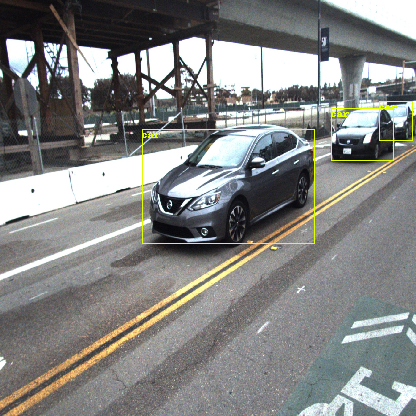

In [5]:
cfg_file = 'yolo3/cfg/yolov3.cfg'
weight_file = 'yolov3.weights'
test_img_one = Image.open("DemoImages/camera6_4208.png").convert('RGB')
test_img_two = Image.open("DemoImages/DifferentModels/1.png").convert('RGB')
test_img_three = Image.open("DemoImages/DifferentModels/2.png").convert('RGB')
test_img_four = Image.open("DemoImages/DifferentModels/3.png").convert('RGB')

detect_one(cfg_file, weight_file, test_img_three)


### Cropped Vehicle Close-Ups using Bounding Boxes

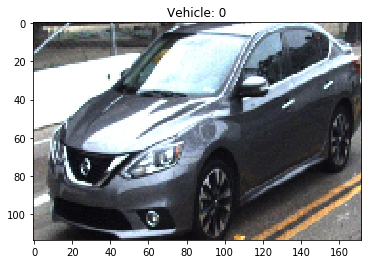

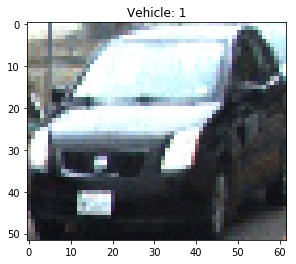

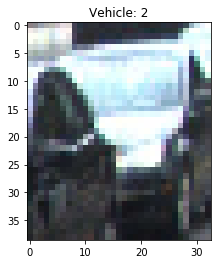

In [6]:
all_objs = classify_models(cfg_file, weight_file, test_img_three)
display_vehicles(all_objs)


# Vehicle Model Classifier

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Part 1 - Preprocessing

In [4]:
train_dir = "images/train"
val_dir = "images/val"

image_size = (224,224)

normalize = tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_set = tv.datasets.ImageFolder(train_dir, tv.transforms.Compose([
    tv.transforms.Resize(image_size),
    tv.transforms.ToTensor(),
    normalize
    ]))

val_set = tv.datasets.ImageFolder(val_dir, tv.transforms.Compose([
    tv.transforms.Resize(image_size),
    tv.transforms.ToTensor(),
    normalize
    ]))

transform = tv.transforms.Compose([
    tv.transforms.Resize(image_size),
    tv.transforms.ToTensor(),
    normalize
    ])


### Part 2 - NN and Stats Manager Set-up

In [5]:
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def criterion(self, y, d):
        return self.cross_entropy(y, d)
    
class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
        
    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0
        
    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())
        
    def summarize(self):
        loss =super(ClassificationStatsManager, self).summarize()
        accuracy = 100 * self.running_accuracy / self.number_update
        return {'loss': loss,'accuracy': accuracy}

def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],label="training loss")
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],label="evaluation loss")
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)],label="training accuracy")
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],label="evaluation accuracy")
    axes[0].legend()
    axes[1].legend()
    axes[0].set_xlabel("Epoch")
    axes[1].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[1].set_ylabel("Accuracy")
    
    plt.tight_layout()
    fig.canvas.draw()

## With Resnet18 Model:

In [6]:
class Resnet18Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(Resnet18Transfer, self).__init__()
        resnet = tv.models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = fine_tuning
        
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.pool1 = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.pool2 = resnet.avgpool
        num_ftrs = resnet.fc.in_features
        self.fc = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        y = self.fc(x)
        return y

In [7]:
lr = 0.001
torch.cuda.empty_cache()
with torch.no_grad():
    net2 = Resnet18Transfer(num_classes=12)
    net2 = net2.to(device)
    adam = torch.optim.Adam(net2.parameters(), lr=lr)
    stats_manager = ClassificationStatsManager()
    exp2 = nt.Experiment(net2, train_set, val_set, adam, stats_manager,output_dir="carclass_resnet18", batch_size=16, perform_validation_during_training=True)

Start/Continue training from epoch 20
Finish training for 20 epochs


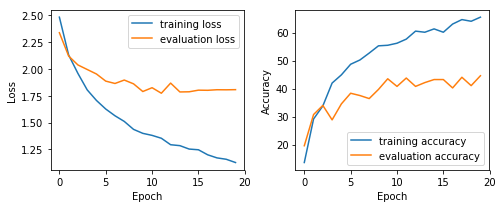

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp2.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

##  TEST

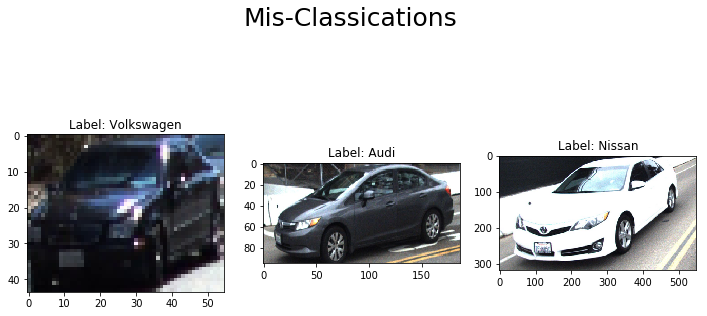

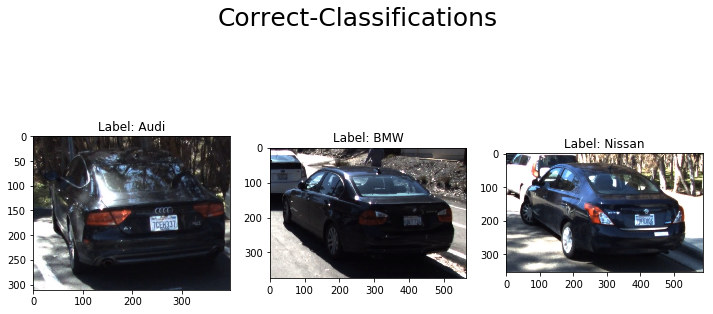

In [9]:
%matplotlib inline
test_imgs = []
fig, axes = plt.subplots(ncols = 3, figsize=(12,6))
plt.suptitle("Mis-Classications", size=25)
for i in range(3):
    img_addr = "images/test/*.png"
    img_addr = img_addr.replace("*", str(i+1))
    test_img = transform(Image.open(img_addr))
    y = exp2.eval_frames(test_img.unsqueeze(0))
#     test_imgs.append(transform(test_img))
    axes[int(i%3)].imshow(Image.open(img_addr))
    axes[int(i%3)].set_title("Label: {}".format(y))
plt.show()

fig1, axes = plt.subplots(ncols = 3, nrows = 1, figsize=(12,6))
plt.suptitle("Correct-Classifications", size=25)
for i in range(3,6):
    img_addr = "images/test/*.png"
    img_addr = img_addr.replace("*", str(i+1))
    test_img = transform(Image.open(img_addr))
    y = exp2.eval_frames(test_img.unsqueeze(0))
#     test_imgs.append(transform(test_img))
    axes[int(i%3)].imshow(Image.open(img_addr))
    axes[int(i%3)].set_title("Label: {}".format(y))
plt.show()

In [10]:
print("Evaluation of model: ", exp2.evaluate())

Evaluation of model:  {'loss': 1.807367687639983, 'accuracy': tensor(44.5652, device='cuda:0')}
